# 01: Linear Regression


In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

## Dataset

I have painstakingly collected 100 days of data on the average happiness (out of 10) of Turing staff in the office based on the number of oranges 🍊 and cups of coffee ☕️ available at the start of the day:

In [2]:
df = pd.read_csv("../data/01_happiness.csv")
df

,oranges,coffee,happy
0,10,528,5.832712
1,12,509,4.648788
2,15,628,4.286937
3,14,389,5.863064
4,13,216,3.109686
...,...,...,...
95,11,293,2.525590
96,15,750,6.802309
97,17,701,6.446739
98,11,832,7.072423


Text(0.5, 0, 'Cups of Coffee')

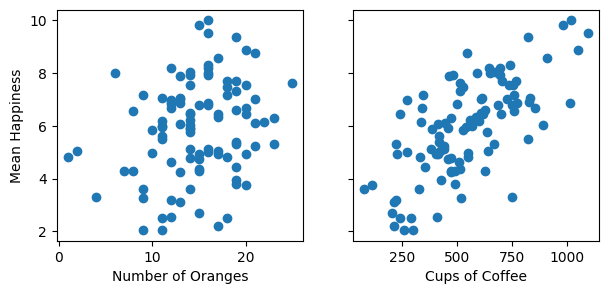

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax[0].scatter(df["oranges"], df["happy"])
ax[0].set_ylabel("Mean Happiness")
ax[0].set_xlabel("Number of Oranges")
ax[1].scatter(df["coffee"], df["happy"])
ax[1].set_xlabel("Cups of Coffee")


## Linear Regression

I want to use the data ~~so I can have more oranges to eat~~ so the Turing can arrange its deliveries to maximise happiness by fitting this model:

$$
\hat{y} = w_1 x_1 + w_2 x_2 + b
$$

where:
- $\hat{y}$ : Predicted Turing happiness
- $x_1$ : Number of oranges available 🍊
  - $w_1$ : Happiness increase per orange
- $x_2$ : Cups of coffee available ☕️
  - $w_2$ : Happiness increase per cup of coffee
- $b$ : Intercept (happiness if no oranges or coffee 😱)


Learn "best" values of $w_1$, $w_2$, and $b$
- how?

## Loss Function

Choose $w_1$, $w_2$, $b$ to minimise the mean squared error between the predicted and actual value:

$$
L = \frac{1}{2N} \sum_{i=1}^{N} (\hat{y_i} - y_i)^2
$$

(divided by 2 to tidy up some maths later)

Here's an example for one choice of $w_1$, $w_2$ and $b$. The loss is the sum of the lengths of the vertical black lines (squared) - the difference between the predicted and actual value:

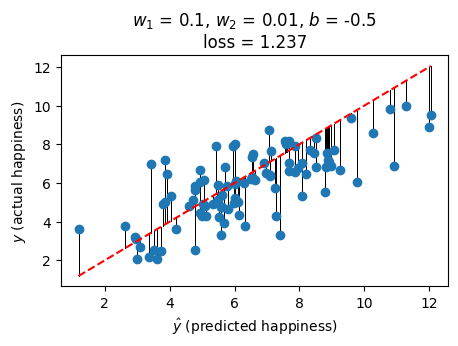

In [4]:
def predict(X, w_1, w_2, b):
    return w_1 * X["oranges"] + w_2 * X["coffee"] + b


def loss(y_hat, y):
    return ((y_hat - y) ** 2).sum() / (2 * len(y))


def plot_predictions(w_1, w_2, b, ax=None):
    y_hat = predict(df[["oranges", "coffee"]], w_1, w_2, b)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.plot(y_hat, df["happy"], "o")
    ax.plot([y_hat.min(), y_hat.max()], [y_hat.min(), y_hat.max()], "r--")
    ax.set_xlabel(r"$\hat{y}$ (predicted happiness)")
    ax.set_ylabel(r"$y$ (actual happiness)")
    ax.set_title(
        f"$w_1$ = {str(w_1)}, $w_2$ = {str(w_2)}, $b$ = {str(b)}\n"
        f"loss = {loss(y_hat, df['happy']):.3f}"
    )
    for _, row in df.iterrows():
        ax.plot([y_hat, y_hat], [y_hat, df["happy"]], color="k", linewidth=0.5, zorder=0)


plot_predictions(0.1, 0.01, -0.5)

We can compute the loss for many different values of $w_1$, $w_2$, and $b$ (here varying only one or two of the parameters due to be able to plot nicely):

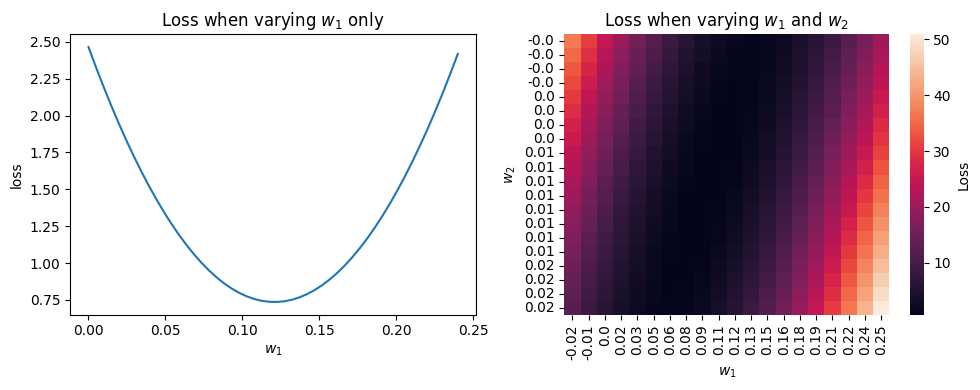

In [5]:
def plot_loss_grid_2d(ax, title=""):
    samples = 20
    W_1 = np.linspace(-0.025, 0.25, samples)
    W_2 = np.linspace(-0.005, 0.02, samples)
    b = 0.885135748052889

    w1_plot = []
    w2_plot = []
    losses = []
    for w_1, w_2 in itertools.product(W_1, W_2):
        w1_plot.append(w_1)
        w2_plot.append(w_2)
        losses.append(loss(predict(df, w_1, w_2, b), df["happy"]))

    sns.heatmap(
        np.array(losses).reshape(samples, samples),
        xticklabels=W_1.round(2),
        yticklabels=W_2.round(2),
        cbar_kws={"label": "Loss"},
        ax=ax,
    )
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_2$")
    ax.set_title(title)


def plot_loss_grid_1d(ax, title=""):
    samples = 50
    W_1 = np.linspace(0, 0.24, samples)
    w_2 = 0.0059909
    b = 0.885135748052889

    w1_plot = []
    losses = []
    for w_1 in W_1:
        w1_plot.append(w_1)
        losses.append(loss(predict(df, w_1, w_2, b), df["happy"]))

    ax.plot(w1_plot, losses)
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("loss")
    ax.set_title(title)

    
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_loss_grid_1d(ax[0], title="Loss when varying $w_1$ only")
plot_loss_grid_2d(ax[1], title="Loss when varying $w_1$ and $w_2$")
fig.tight_layout()

The best choice of $w_1$, $w_2$, and $b$ is the one that minimises the loss (the bottom of the valleys above) - how to find where that is?

## Gradient Descent

The loss function again (expanded to include the definition of $\hat{y}$):

$$
L = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y_i} - y_i)^2 = \frac{1}{2m} \sum_{i=1}^{m} (w_1 x_{1,i} + w_2 x_{2,i} + b - y)^2
$$

The minimum loss will be found where the partial derivatives of the loss function with respect to the parameters is zero:

$$
\frac{\partial L}{\partial w_1} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y_i} - y_i) x_{1,i} \\
\frac{\partial L}{\partial w_2} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y_i} - y_i) x_{1,i} \\
\frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y_i} - y_i)
$$

Above I've replaced $N$, the number of samples in the dataset, with $m \leq N$, to indicate that we could choose to update the parameters based on the loss of a subset of the data.

$m$ is known as the **batch size**

Different values of $m$ correspond to different forms of gradient descent:

- $m = N$ : Batch Gradient Descent (or just Gradient Descent)
- $1 < m < N$ : Mini Batch Gradient Descent (or Mini Batch Stochastic Gradient Descent)
- $m = 1$: Stochastic Gradient Descent

The random (stochastic) nature of mini batch and stochastic gradient descent come from needing to select a sample of the dataset for each parameter update.

Broadly:
- Batch gradient descent: Slower, better convergence
- (Mini batch) stochastic gradient descent: Faster, worse convergence

We can pick some initial values for $w_1$, $w_2$, and $b$, and then iteratively update them towards the values that will zero the partial derivatives of the loss:

$$
w_1 = w_1 - \alpha \frac{\partial L}{\partial w_1} \\
w_2 = w_2 - \alpha\frac{\partial L}{\partial w_2} \\
b = b - \alpha\frac{\partial L}{\partial b}
$$

where $\alpha$ is the "learning rate" (or the relative size of the parameter updates we're going to make after each iteration)

The learning rate is a hyperparameter:
- $\alpha$ too large - gradient descent may not converge
- $\alpha$ too small - gradient descent will take too long to converge

Gradient descent will converge faster if all the features are on the same scale, so we can standardise them (to have mean zero and standard deviation of one):

In [6]:
for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

df.describe()

,oranges,coffee,happy
count,1.000000e+02,1.000000e+02,1.000000e+02
mean,-6.661338e-17,6.217249e-17,-5.817569e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.094917e+00,-2.163980e+00,-2.121838e+00
25%,-6.171814e-01,-6.119499e-01,-6.178392e-01
50%,5.856466e-02,-1.085261e-01,8.677973e-02
75%,7.343107e-01,6.999679e-01,6.344933e-01
max,2.311051e+00,2.550109e+00,2.220604e+00


Here's a basic implementation of batch gradient descent:

In [7]:
def gradient_descent(df, learning_rate=0.001, epochs=1000):
    w_1 = 0
    w_2 = 0
    b = 0
    X = df[["oranges", "coffee"]]
    y = df["happy"]
    losses = []
    for e in range(epochs):
        l = loss(predict(X, w_1, w_2, b), y)
        losses.append(l)

        y_hat = predict(X, w_1, w_2, b)
        delta = y_hat - y
        w_1 = w_1 - (learning_rate / len(y)) * (delta * X["oranges"]).sum()
        w_2 = w_2 - (learning_rate / len(y)) * (delta * X["coffee"]).sum()
        b = b - (learning_rate / len(y)) * delta.sum()

    return w_1, w_2, b, losses

The number of **epochs** is how many times we'll loop through the entire dataset before stopping (updating the parameters after each _batch_, though in this case we only have one batch per epoch - the entire dataset).

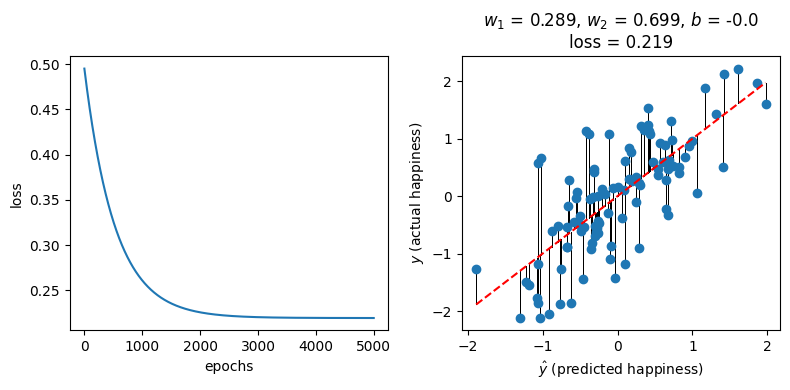

In [8]:
w_1, w_2, b, l = gradient_descent(df, learning_rate=0.001, epochs=5000)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(l)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
plot_predictions(round(w_1, 3), round(w_2, 3), round(b, 3), ax[1])
fig.tight_layout()


## Neural Network for Linear Regression

![](../img/01_linear_regression_net.png)

**Dense** layer: All nodes in the previous layer are connected to all the nodes in the next layer

## Pytorch

[pytorch](https://pytorch.org/) and [tensorflow](https://www.tensorflow.org/) are two of the most well-known deep learning libraries.

Here is our linear regression model expressed as a pytorch neural network:

In [9]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=1),
)
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


`nn.Sequential` builds a neural network from a sequence of layers - for our model a single "linear layer" with 2 inputs ($x_1$, $x_2$) and 1 output ($\hat{y}$).

The layer specification is enough for pytorch to know the parameters we have to learn, and these are given random initial values (see [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)):

In [10]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:]} \n")


Layer: 0.weight | Size: torch.Size([1, 2]) | Values : tensor([[-0.2148,  0.5047]], grad_fn=<SliceBackward0>) 

Layer: 0.bias | Size: torch.Size([1]) | Values : tensor([0.0981], grad_fn=<SliceBackward0>) 



As before we have 2 weights ($w_1$ and $w_2$, but now both  in `0.weight`), and an intercept or **bias** term ($b$ before, and now in `0.bias`).

pytorch works with its own "tensor" data structure (like a numpy array optimised for working with GPUs and automatic differentiation), so we need to convert our data:

In [11]:
X = torch.tensor(df[["oranges", "coffee"]].values, dtype=torch.float)

y = torch.tensor(df["happy"].values, dtype=torch.float)
y = y[:, None]  # output needs to be 2D, [:, None] adds a second (length 1) axis

To get predictions from the model (using the randomly initialised weights at this stage), just pass it the data:

In [12]:
model(X[:10])

tensor([[ 0.2867],
        [ 0.1455],
        [ 0.2790],
        [-0.2323],
        [-0.5890],
        [-0.0911],
        [ 0.2751],
        [ 0.0886],
        [-0.4687],
        [-0.0083]], grad_fn=<AddmmBackward0>)

This is called a **forward pass** through the network (start with data at the input layer and pass it forward through the network to get predictions at the output layer).

Time to optimise the parameters (train the network). We can use pytorch's built-in mean-squared-error (MSE) loss function class:

In [13]:
loss_fn = nn.MSELoss()

And its own implementation of stochastic gradient descent (SGD):

In [14]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Then define a function to train the network:

(NB: usually this would include a 2nd inner loop over _batches_, but here we're updating the parameters on the entire dataset at each iteration)

In [15]:
def train(X, y, model, loss_fn, optimizer, epochs):
    loss_history = []
    for e in range(epochs):
        # Compute prediction and loss
        pred = model(X)
        loss_value = loss_fn(pred, y)
        loss_history.append(float(loss_value))

        # Backpropagation
        optimizer.zero_grad()  # without this the optimiser would accumulate the gradients between epochs
        loss_value.backward()
        optimizer.step()

    print("Done!")
    return model, loss_history


In each epoch there are two main steps:

1. **Forward pass:** Predict and compute the loss with the current parameter values
2. **Back propagation:** Use the loss and the gradients (partial derivatives) to update the parameter values


Let's go!

In [16]:
model, loss_history = train(X, y, model, loss_fn, optimizer, 15000)

Done!


We get a similar fit (and loss) to our "more conventional" linear regression implementation from before:

Layer: 0.weight | Size: torch.Size([1, 2]) | Values : tensor([[0.2929, 0.7050]], grad_fn=<SliceBackward0>) 

Layer: 0.bias | Size: torch.Size([1]) | Values : tensor([-7.9423e-10], grad_fn=<SliceBackward0>) 



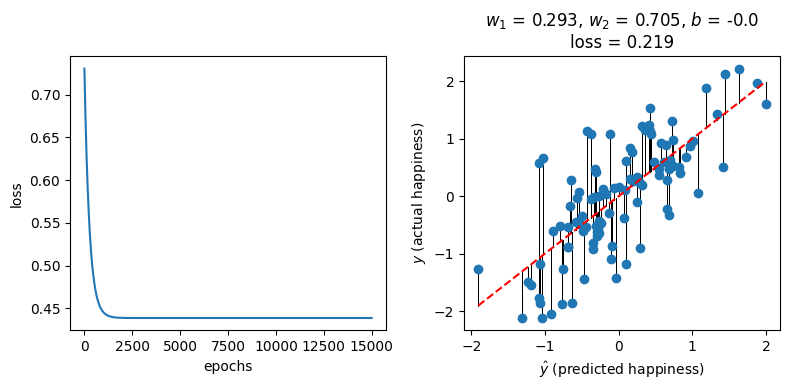

In [17]:
params = []
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:]} \n")
    params.append(param.detach().numpy())

w_1 = params[0][0][0]
w_2 = params[0][0][1]
b = params[1][0]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(loss_history)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
plot_predictions(round(w_1, 3), round(w_2, 3), round(b, 3), ax[1])
fig.tight_layout()


## Adding nodes and layers

Here's a slightly bigger network (but with only one input feature, $x$):

![](../img/01_two_hidden_layers.png)

- Additional layers between the input and output layer are known as **hidden layers**.
- All of the nodes have an implicit _bias_ / intercept term as before, they're just not shown.
- All the layers are still _dense_ layers (each node connected to all the nodes in the next layer)

Example output from a node in the first hidden layer:

$$
h_{(1,1)} = w_{x\rightarrow(1,1)} x + b_{(1,1)}
$$

Example output from a node in the second hidden layer:

$$
h_{(2,1)} = w_{(1,1)\rightarrow(2,1)} h_{(1,1)} + w_{(1,2)\rightarrow(2,1)} h_{(1,2)} + w_{(1,3)\rightarrow(2,1)} h_{(1,3)} + b_{(2,1)}
$$

Final output:

$$
\hat{y} = w_{(2,1)\rightarrow y} h_{(2,1)} + w_{(2,2)\rightarrow y}h_{(2,2)} + b_{y}
$$

The weights and biases aren't labeled on the diagram, but the notation $w_{(1,3)\rightarrow(2,1)}$ means the arrow from node 3 in the first hidden layer, to node 1 in the second hidden layer.

Here's the network implemented in pytorch:

In [18]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=3),
    nn.Linear(in_features=3, out_features=2),
    nn.Linear(in_features=2, out_features=1),
)
print(model)

print("\n------ Parameters ------\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}\n")


Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): Linear(in_features=3, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=1, bias=True)
)

------ Parameters ------

Layer: 0.weight | Size: torch.Size([3, 1])

Layer: 0.bias | Size: torch.Size([3])

Layer: 1.weight | Size: torch.Size([2, 3])

Layer: 1.bias | Size: torch.Size([2])

Layer: 2.weight | Size: torch.Size([1, 2])

Layer: 2.bias | Size: torch.Size([1])



Note the the number of weights in each layer matches the number of arrows in the diagram (3 to the first hidden layer, 6 to the second hidden layer, and 2 to the output layer). Plus there's one bias (intercept) term per node in the network.

## What types of functions can this network learn?

a) Linear (with terms up to $x$)

b) Quadratic (with terms up to $x^2$)

c) Cubic (with terms up to $x^3$)

d) Higher order


Remember that:
- Our first example with only an input and output layer could fit a _linear_ function.
- This new network has two additional (hidden) layers

## Can the network learn $y = x^2$ ?

In [19]:
X = np.linspace(-1, 1, 1000)
y = X**2

X = torch.tensor(X, dtype=torch.float)[:, None]
y = torch.tensor(y, dtype=torch.float)
y = y[:, None]

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model, loss_history = train(X, y, model, loss_fn, optimizer, 10000)


Done!


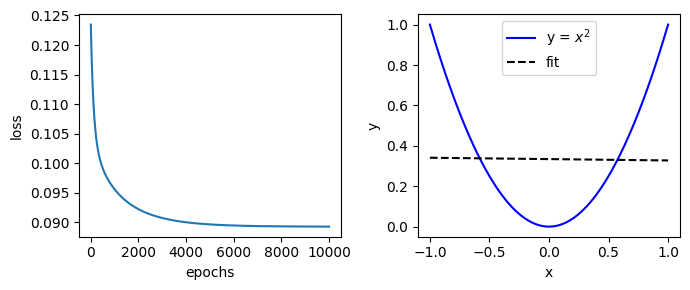

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].plot(loss_history)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[1].plot(X.numpy(), y.numpy(), "b", label="y = $x^2$")
ax[1].plot(X.numpy(), model(X).detach().numpy(), "k--", label="fit")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].legend()
fig.tight_layout()

No! The new neural network is still a linear regression model that could be reduced to $\hat{y} = wx + b$.

## Why?

The neural network can be broken down in to two main mini-structures (that can appear anywhere in the network, not necessarily in the input and output layers as shown below):

![](../img/01_mini_networks.png)

Left: The linear regression model we fit in the first example earlier.

Right: Wasn't intuitive to me that this is still 1st-order linear regression (I would have guessed the extra layer creates an $x^2$ term). So I had to write it out:

$$
h = w_x x + b_h \\
\hat{y} = w_h h + b_y \\
\hat{y} = w_h(w_x x + b_h) + b_y \\
\hat{y} = (w_h w_x) x + (w_h b_h + b_y)
$$

The weights get multiplied, but not the input features.

## What's missing?

We need the output from each node to be a non-linear function of its inputs.

Activation functions - Part 2.